# 导入包和文件

In [43]:
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import openpyxl
plt.rcParams['font.sans-serif'] = ['SimHei']#设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False #正常显示负号
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tabpy_client
client = tabpy_client.Client('http://localhost:9004')

In [44]:
df_path = 'D:\\dataanalyse\\learning_materials\\大工具课第二期\\自己实操\\毕设\\KNN用户画像聚类分析\\用户画像数据.xlsx'
df = pd.read_excel(df_path)

In [45]:
df.head()

,用户编号,一级品类,二级品类,二级品类变号,流水号,产品描述,会员创建日期,销售日期,销售金额
0,10659354,服孕,内衣,930100,TJ157114012200004,产检裤,2012-04-21,2019-01-22,25.8
1,10659365,奶粉,婴儿奶粉,101030,BJ164214072100015,听装,2012-04-21,2019-07-21,436.0
2,1065943,食品,营养品,121310,QD134114010100025,混合粉,2010-04-11,2019-01-01,954.0
3,1065943,童附,小配件,920100,QD134114010100025,口罩,2010-04-11,2019-01-01,12.0
4,1065943,食品,营养品,121110,QD134114010100025,补钙,2010-04-11,2019-01-01,68.0


# 数据预处理

## 数据筛选

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65989 entries, 0 to 65988
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   用户编号    65989 non-null  int64         
 1   一级品类    65989 non-null  object        
 2   二级品类    65989 non-null  object        
 3   二级品类变号  65989 non-null  int64         
 4   流水号     65989 non-null  object        
 5   产品描述    65989 non-null  object        
 6   会员创建日期  65989 non-null  datetime64[ns]
 7   销售日期    65989 non-null  datetime64[ns]
 8   销售金额    65989 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 4.5+ MB


In [47]:
#关键变量的提取
df = df.loc[:,['用户编号','销售日期','销售金额']]
df

,用户编号,销售日期,销售金额
0,10659354,2019-01-22,25.8
1,10659365,2019-07-21,436.0
2,1065943,2019-01-01,954.0
3,1065943,2019-01-01,12.0
4,1065943,2019-01-01,68.0
...,...,...,...
65984,11112222,2019-04-01,11.1
65985,11112222,2019-03-24,44.5
65986,11112222,2019-04-01,4.0
65987,11112222,2019-03-24,44.5


## R = 最近一次消费时间 - 当前提取数据的时间 

In [59]:
df1 = df[['用户编号','销售日期','销售金额']]

In [60]:
df.销售日期.describe()

count                   65989
unique                    205
top       2019-05-25 00:00:00
freq                      614
first     2019-01-01 00:00:00
last      2019-07-24 00:00:00
Name: 销售日期, dtype: object

In [61]:
df1['R'] = (pd.to_datetime('2019-07-25') - df['销售日期']).dt.days
df1 = df1[['用户编号','销售日期','销售金额','R']]
df1

,用户编号,销售日期,销售金额,R
0,10659354,2019-01-22,25.8,184
1,10659365,2019-07-21,436.0,4
2,1065943,2019-01-01,954.0,205
3,1065943,2019-01-01,12.0,205
4,1065943,2019-01-01,68.0,205
...,...,...,...,...
65984,11112222,2019-04-01,11.1,115
65985,11112222,2019-03-24,44.5,123
65986,11112222,2019-04-01,4.0,115
65987,11112222,2019-03-24,44.5,123


## F = 订单频次、购买频次

In [63]:
df2=df1.groupby('用户编号').agg({'R':'min','销售金额':'sum'})
df2

,R,销售金额
用户编号,,
641397,90,382.9
643162,8,46.6
643568,153,10.5
647700,43,115.0
650671,124,20.8
...,...,...
14433489,10,399.0
14433518,10,195.0
14433583,10,23.8


In [68]:
df2['F'] = df1.groupby(['用户编号'])['用户编号'].size()
df2

,R,销售金额,F
用户编号,,,
641397,90,382.9,15
643162,8,46.6,2
643568,153,10.5,1
647700,43,115.0,5
650671,124,20.8,1
...,...,...,...
14433489,10,399.0,2
14433518,10,195.0,5
14433583,10,23.8,1


In [75]:
df2.to_excel('RFM.xlsx')

# KNN算法建模 

## 算法实现

In [112]:
data1 = pd.read_excel('D:\\dataanalyse\\learning_materials\\大工具课第二期\\自己实操\\毕设\\RFM.xlsx')

In [113]:
data1

,用户编号,R,销售金额,F
0,641397,90,382.9,15
1,643162,8,46.6,2
2,643568,153,10.5,1
3,647700,43,115.0,5
4,650671,124,20.8,1
...,...,...,...,...
7173,14433489,10,399.0,2
7174,14433518,10,195.0,5
7175,14433583,10,23.8,1
7176,14434092,10,354.2,10


In [114]:
X1 = data1[['R','F','销售金额']].values
y1 = KMeans(n_clusters=4,random_state=1)
y1_pred = y1.fit_predict(X1)   #训练模型，将标签值返回到y_pred
y1_pred = y1_pred.reshape(len(X1),1)   #将标签值由行转为列
data1['客户类别'] = y1_pred 

In [97]:
data1

,用户编号,R,销售金额,F,客户类别
0,641397,90,382.9,15,0
1,643162,8,46.6,2,0
2,643568,153,10.5,1,0
3,647700,43,115.0,5,0
4,650671,124,20.8,1,0
...,...,...,...,...,...
7173,14433489,10,399.0,2,0
7174,14433518,10,195.0,5,0
7175,14433583,10,23.8,1,0
7176,14434092,10,354.2,10,0


In [118]:
data1.to_excel('RFMfinal2.xlsx')

In [116]:
data.groupby(['客户类别']).count()

,R,F,M
客户类别,,,
0,5867,5867,5867
1,261,261,261
2,64,64,64
3,986,986,986


### RFM客户价值说明
    0 # 一星客户（一般发展客户）
    3 # 二星客户（一般保持客户）
    1 # 三星客户（重要保持客户）
    2 # 四星客户（重要挽留客户）

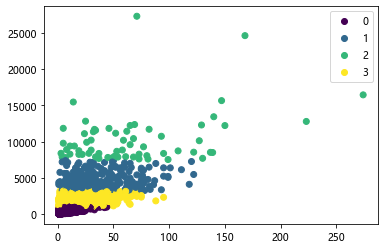

In [117]:
scatter = plt.scatter(X1[:,1],X1[:,2],c=y1_pred) 
plt.legend(*scatter.legend_elements()) 
plt.show()

## 函数部署

In [132]:
def kmean(R,F,M):
    dic = {'最近消费时间':R,'消费次数':F,'消费金额':M}
    RFM = pd.DataFrame(dic)
    
    X_rfm = RFM[['最近消费时间','消费次数','消费金额']]
    y_rfmpredict = y1.fit_predict(X_rfm)
    return y_rfmpredict.tolist()

In [140]:
#验证函数
kmean([12,97,12,23],
     [33,3,28,233],
     [11681,8372,8370,12776])

[2, 0, 3, 1]

In [141]:
client.deploy(name = 'kmean',obj = kmean,override = True) 
print('成功部署函数')

成功部署函数
